In [2]:
# Repair/Load cell for tickets.csv 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd, numpy as np, csv, os
from pathlib import Path

PROJ = Path("/Users/mahithahemadri/Downloads/Projects/SupportOps_SLA_Backlog")
DATA = PROJ / "data"; DATA.mkdir(parents=True, exist_ok=True)
tickets_fp = DATA / "tickets.csv"

need_cols = {"ticket_id","created_at","first_response_at","resolved_at","priority","channel","queue","aht_min"}

def generate_tickets_csv(path: Path, n=35000):
    rng = np.random.default_rng(42)
    start = pd.Timestamp("2024-04-01 00:00:00"); end = pd.Timestamp("2024-05-15 23:59:59")
    minutes = pd.date_range(start, end, freq="min")
    grid = pd.DataFrame({"ts": minutes})
    grid["dow"] = grid.ts.dt.dayofweek; grid["hour"] = grid.ts.dt.hour
    base = (0.20 + 0.60*((grid["dow"]<5)&(grid["hour"].between(9,18))) + 0.15*(grid["hour"].between(18,22)))
    prob = (base/base.sum()).to_numpy()
    idx = np.sort(rng.choice(len(grid), size=n, replace=True, p=prob))
    created_at = grid.ts.iloc[idx].to_numpy()

    priority = rng.choice(["P1","P2","P3"], size=n, p=[0.08,0.62,0.30])
    channel  = rng.choice(["Email","Web","Chat"], size=n, p=[0.55,0.35,0.10])
    queue    = rng.choice(["Billing","Tech","General"], size=n, p=[0.35,0.45,0.20])

    base_frt = (np.where(channel=="Chat", np.random.normal(8,6,n),
               np.where(channel=="Web",  np.random.normal(35,20,n), np.random.normal(90,45,n)))
               - np.where(priority=="P1", 20, np.where(priority=="P2", 0, -10)))
    frt_min = np.round(base_frt + np.random.normal(0,4,n)).clip(0, 24*60)
    first_response_at = pd.to_datetime(created_at) + pd.to_timedelta(frt_min, unit="m")

    aht = np.where(queue=="Tech",    np.random.lognormal(3.5,0.6,n),
          np.where(queue=="Billing", np.random.lognormal(3.2,0.5,n), np.random.lognormal(3.0,0.45,n)))
    aht = np.round(aht).clip(3, 8*60)
    resolved_at = pd.to_datetime(first_response_at) + pd.to_timedelta(aht, unit="m")

    df = pd.DataFrame({
        "ticket_id": np.arange(1, n+1),
        "created_at": pd.to_datetime(created_at),
        "first_response_at": pd.to_datetime(first_response_at),
        "resolved_at": pd.to_datetime(resolved_at),
        "priority": priority,
        "channel": channel,
        "queue": queue,
        "aht_min": aht.astype(int)
    })
    df.to_csv(path, index=False)
    return df

regen = False
reason = ""

if not tickets_fp.exists():
    regen, reason = True, "tickets.csv not found"
else:
    try:
        # Peek header only
        with open(tickets_fp, "r", newline="") as f:
            reader = csv.reader(f)
            header = next(reader, [])
        if not header:
            regen, reason = True, "tickets.csv is empty"
        elif not (set(header) >= need_cols):
            regen, reason = True, f"missing columns: {sorted(list(need_cols - set(header)))}"
    except Exception as e:
        regen, reason = True, f"could not read header ({e})"

if regen:
    print(f"Regenerating tickets.csv → {reason}")
    tickets = generate_tickets_csv(tickets_fp)
else:
    # Robust load: let pandas detect delimiter; then parse dates that exist
    tmp = pd.read_csv(tickets_fp, sep=None, engine="python", nrows=5)
    date_cols = [c for c in ["created_at","first_response_at","resolved_at"] if c in tmp.columns]
    tickets = pd.read_csv(tickets_fp, sep=None, engine="python", parse_dates=date_cols)

print("Path:", tickets_fp)
print("Columns:", list(tickets.columns))
print("Rows:", len(tickets))
tickets.head(3)

Regenerating tickets.csv → missing columns: ['aht_min', 'created_at', 'first_response_at', 'queue', 'resolved_at']
Path: /Users/mahithahemadri/Downloads/Projects/SupportOps_SLA_Backlog/data/tickets.csv
Columns: ['ticket_id', 'created_at', 'first_response_at', 'resolved_at', 'priority', 'channel', 'queue', 'aht_min']
Rows: 35000


,ticket_id,created_at,first_response_at,resolved_at,priority,channel,queue,aht_min
0,1,2024-04-01 00:01:00,2024-04-01 00:41:00,2024-04-01 01:13:00,P2,Email,Tech,32
1,2,2024-04-01 00:02:00,2024-04-01 01:29:00,2024-04-01 01:48:00,P2,Email,General,19
2,3,2024-04-01 00:06:00,2024-04-01 00:33:00,2024-04-01 01:19:00,P2,Email,Tech,46


In [3]:
# SLA policy
SLA = {
    "P1": {"target_min": 15,      "service_level": 0.90},  # 90% within 15 min
    "P2": {"target_min": 60,      "service_level": 0.80},  # 80% within 60 min
    "P3": {"target_min": 24*60,   "service_level": 0.80},  # 80% within 24h
}
INTERVAL_MIN = 30  # staffing block size in minutes

In [4]:
# Per-ticket metrics, then daily rollups
tickets["frt_min"] = (tickets["first_response_at"] - tickets["created_at"]).dt.total_seconds()/60.0
tickets["ttr_min"] = (tickets["resolved_at"]       - tickets["created_at"]).dt.total_seconds()/60.0
tickets["day"]     = tickets["created_at"].dt.date

grp = tickets.groupby(["day","priority","channel","queue"], as_index=False)
kpis_daily = grp.agg(
    tickets=("ticket_id","count"),
    avg_frt_min=("frt_min","mean"),
    avg_ttr_min=("ttr_min","mean"),
    p50_frt=("frt_min", lambda s: np.nanpercentile(s, 50)),
    p90_frt=("frt_min", lambda s: np.nanpercentile(s, 90)),
    p50_ttr=("ttr_min", lambda s: np.nanpercentile(s, 50)),
    p90_ttr=("ttr_min", lambda s: np.nanpercentile(s, 90)),
)
kpis_daily.to_csv(OUT/"daily_kpis_by_seg.csv", index=False)
kpis_daily.head()

,day,priority,channel,queue,tickets,avg_frt_min,avg_ttr_min,p50_frt,p90_frt,p50_ttr,p90_ttr
0,2024-04-01,P1,Chat,Billing,3,0.00,35.333333,0.0,0.0,38.0,38.8
1,2024-04-01,P1,Chat,General,2,1.50,19.000000,1.5,2.7,19.0,25.4
2,2024-04-01,P1,Chat,Tech,5,0.00,49.400000,0.0,0.0,27.0,97.0
3,2024-04-01,P1,Email,Billing,16,67.75,95.437500,73.0,120.0,92.5,155.0
4,2024-04-01,P1,Email,General,5,84.00,100.000000,69.0,151.8,87.0,172.6


In [5]:
# SLA hit rate per day & priority
rows = []
for (d, p), g in tickets.groupby(["day","priority"]):
    target = SLA[p]["target_min"]
    hit_rate = (g["frt_min"] <= target).mean() if len(g) else np.nan
    rows.append({"day": d, "priority": p, "tickets": len(g), "hit_rate": hit_rate, "target_min": target})
sla_daily = pd.DataFrame(rows).sort_values(["day","priority"])
sla_daily.to_csv(OUT/"sla_daily_by_priority.csv", index=False)
sla_daily.head()

,day,priority,tickets,hit_rate,target_min
0,2024-04-01,P1,73,0.315068,15
1,2024-04-01,P2,565,0.532743,60
2,2024-04-01,P3,286,1.000000,1440
3,2024-04-02,P1,63,0.253968,15
4,2024-04-02,P2,571,0.574431,60


In [9]:
# Arrivals per interval (lambda) and AHT
from IPython.display import display

tickets["interval"] = tickets["created_at"].dt.floor(f"{INTERVAL_MIN}T")

aht_by_seg = tickets.groupby(["priority","channel","queue"], as_index=False)["aht_min"].mean()
aht_by_seg.to_csv(OUT/"aht_by_segment.csv", index=False)

workload = (tickets.groupby(["interval","priority"], as_index=False)
                   .agg(arrivals=("ticket_id","count")))
workload["lambda_per_min"] = workload["arrivals"] / INTERVAL_MIN
workload.to_csv(OUT/"workload_by_interval_priority.csv", index=False)

display(workload.head(10))    
display(aht_by_seg.head(10))

,interval,priority,arrivals,lambda_per_min
0,2024-04-01 00:00:00,P1,2,0.066667
1,2024-04-01 00:00:00,P2,7,0.233333
2,2024-04-01 00:00:00,P3,4,0.133333
3,2024-04-01 00:30:00,P2,3,0.100000
4,2024-04-01 00:30:00,P3,4,0.133333
5,2024-04-01 01:00:00,P2,8,0.266667
6,2024-04-01 01:00:00,P3,4,0.133333
7,2024-04-01 01:30:00,P2,3,0.100000
8,2024-04-01 01:30:00,P3,3,0.100000
9,2024-04-01 02:00:00,P2,7,0.233333


,priority,channel,queue,aht_min
0,P1,Chat,Billing,27.515152
1,P1,Chat,General,23.481481
2,P1,Chat,Tech,41.234375
3,P1,Email,Billing,28.856855
4,P1,Email,General,22.372549
5,P1,Email,Tech,39.714514
6,P1,Web,Billing,28.035616
7,P1,Web,General,21.431925
8,P1,Web,Tech,40.280738
9,P2,Chat,Billing,27.318362


In [10]:
# Erlang C toolkit (M/M/c)
import math

def erlang_c(a, c):
    """a = traffic (erlangs) = λ/μ; c = agents; returns P(wait>0)"""
    if c <= 0: return 1.0
    rho = a / c
    if rho >= 1:  # unstable
        return 1.0
    summ = sum(a**k / math.factorial(k) for k in range(c))
    last = (a**c / math.factorial(c)) * (1 / (1 - rho))
    p0 = 1.0 / (summ + last)
    return last * p0

def service_level(lambda_per_min, aht_min, c, target_minutes):
    """SL ≈ 1 − ErlangC * exp(−(c·μ − λ)·T)"""
    mu = 1.0 / max(aht_min, 1e-9)
    a  = lambda_per_min / mu
    if c <= 0 or c*mu <= lambda_per_min:
        return 0.0
    ec = erlang_c(a, c)
    return 1.0 - ec * math.exp(-(c*mu - lambda_per_min) * target_minutes)

def min_agents(lambda_per_min, aht_min, target_minutes, target_sl, cap=200):
    """Smallest c meeting SL target."""
    for c in range(1, cap+1):
        if service_level(lambda_per_min, aht_min, c, target_minutes) >= target_sl:
            return c
    return cap

In [11]:
# Agents needed per 30-min interval for each priority
aht_by_pri = tickets.groupby("priority", as_index=False)["aht_min"].mean()

reco = []
for (iv, p), g in workload.groupby(["interval","priority"]):
    lam = float(g["lambda_per_min"].iloc[0])
    aht = float(aht_by_pri.loc[aht_by_pri.priority==p, "aht_min"].iloc[0])
    target_T  = SLA[p]["target_min"]
    target_SL = SLA[p]["service_level"]
    c = min_agents(lam, aht, target_T, target_SL)
    achieved = service_level(lam, aht, c, target_T)
    reco.append({
        "interval": iv, "priority": p,
        "lambda_per_min": lam, "aht_min": aht,
        "target_min": target_T, "target_sl": target_SL,
        "agents_needed": int(c), "achieved_sl": round(achieved,3)
    })

staffing = pd.DataFrame(reco).sort_values(["interval","priority"])
staffing.to_csv(OUT/"staffing_recommendation_by_priority.csv", index=False)
staffing.head()

,interval,priority,lambda_per_min,aht_min,target_min,target_sl,agents_needed,achieved_sl
0,2024-04-01 00:00:00,P1,0.066667,32.343300,15,0.9,4,0.909
1,2024-04-01 00:00:00,P2,0.233333,31.908923,60,0.8,9,0.973
2,2024-04-01 00:00:00,P3,0.133333,31.832986,1440,0.8,5,1.000
3,2024-04-01 00:30:00,P2,0.100000,31.908923,60,0.8,4,0.871
4,2024-04-01 00:30:00,P3,0.133333,31.832986,1440,0.8,5,1.000


In [12]:
# One combined agent count per interval (conservative = max across priorities)
combined = staffing.groupby("interval", as_index=False)["agents_needed"].max()
combined.rename(columns={"agents_needed":"agents_needed_combined"}, inplace=True)
combined.to_csv(OUT/"staffing_schedule_combined.csv", index=False)
combined.head()

,interval,agents_needed_combined
0,2024-04-01 00:00:00,9
1,2024-04-01 00:30:00,5
2,2024-04-01 01:00:00,10
3,2024-04-01 01:30:00,4
4,2024-04-01 02:00:00,9


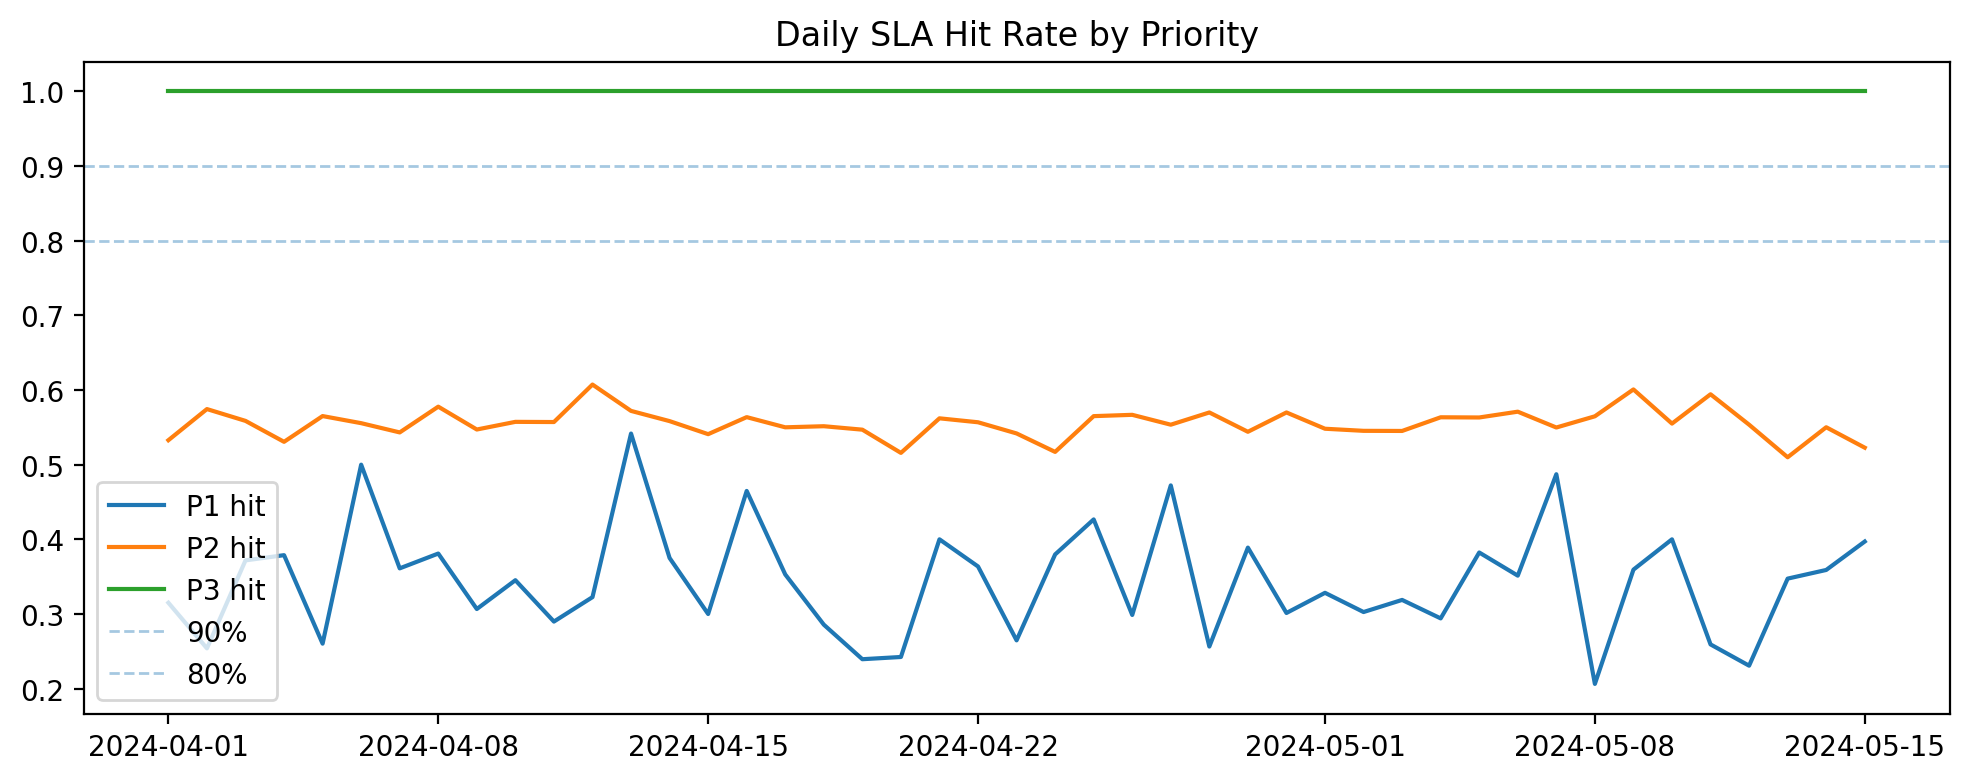

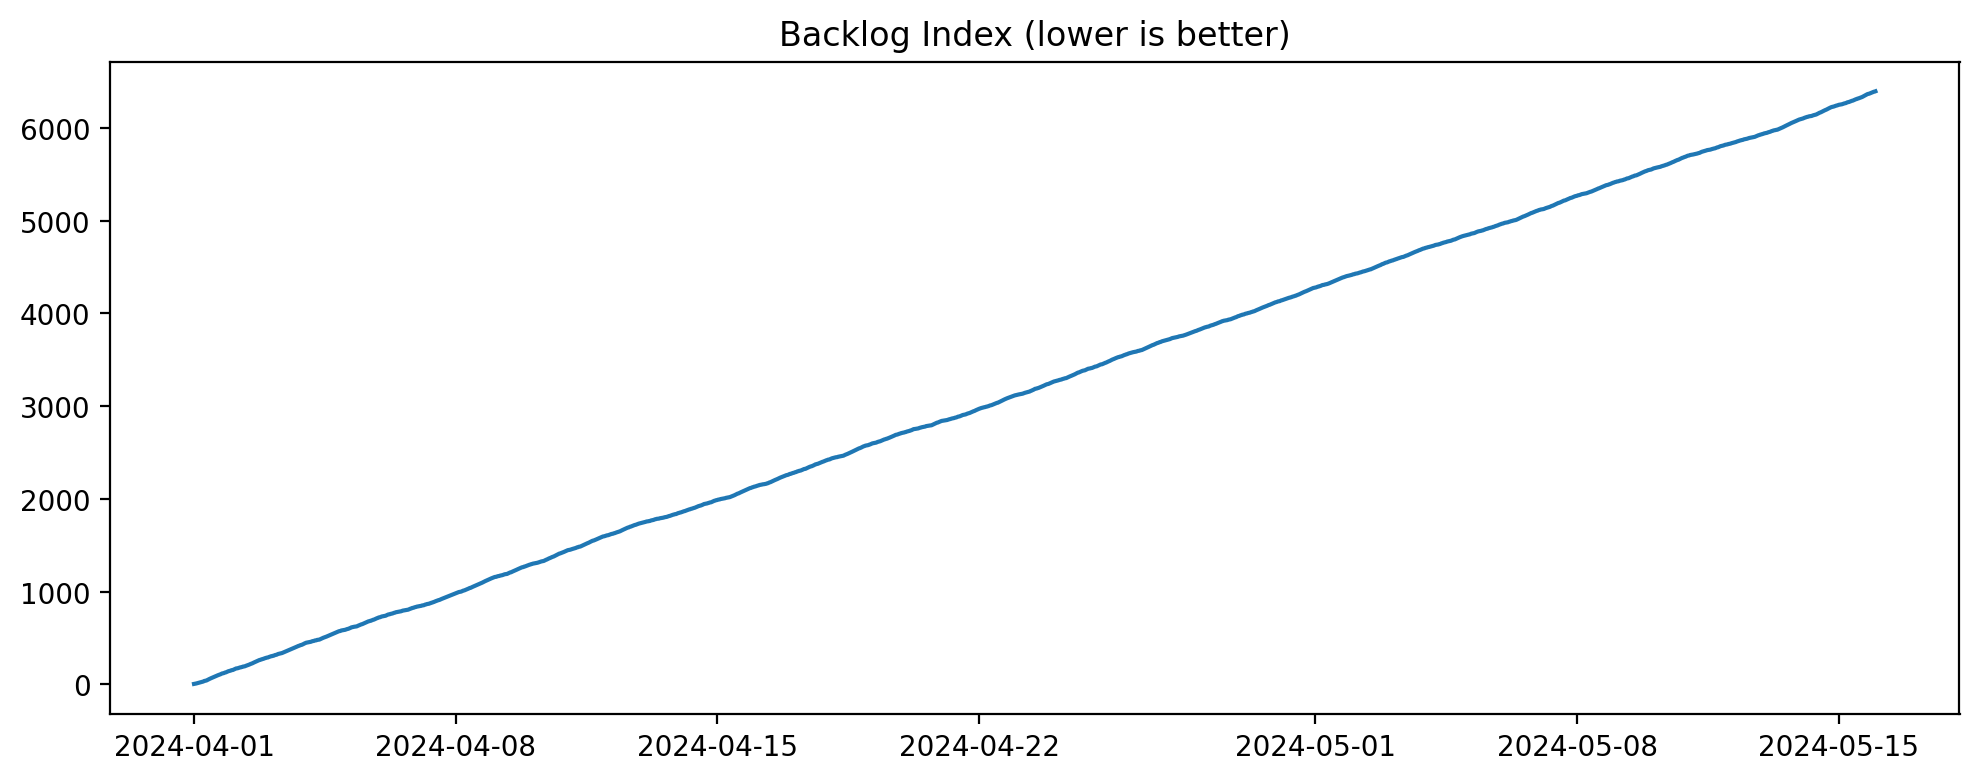

In [13]:
#  Daily SLA hit trend
plt.figure(figsize=(10,4))
for p in ["P1","P2","P3"]:
    s = sla_daily.loc[sla_daily["priority"]==p, ["day","hit_rate"]]
    if len(s):
        plt.plot(pd.to_datetime(s["day"]), s["hit_rate"], label=f"{p} hit")
plt.axhline(0.9, ls="--", lw=1, alpha=0.4, label="90%")
plt.axhline(0.8, ls="--", lw=1, alpha=0.4, label="80%")
plt.title("Daily SLA Hit Rate by Priority"); plt.legend(); plt.tight_layout(); plt.show()

# Backlog index (simple proxy)
mu_blend = 1.0 / tickets["aht_min"].mean()
agents_sum = staffing.groupby("interval", as_index=False)["agents_needed"].sum()
lam_total  = workload.groupby("interval", as_index=False)["lambda_per_min"].sum()
cap = agents_sum.merge(lam_total, on="interval", how="left")
cap["net_rate"] = cap["agents_needed"]*mu_blend - cap["lambda_per_min"]
cap["backlog_idx"] = (cap["net_rate"].fillna(0).cumsum() * INTERVAL_MIN).clip(lower=0)

cap[["interval","agents_needed","lambda_per_min","net_rate","backlog_idx"]].to_csv(
    OUT/"backlog_index.csv", index=False
)

plt.figure(figsize=(10,4))
plt.plot(cap["interval"], cap["backlog_idx"])
plt.title("Backlog Index (lower is better)"); plt.tight_layout(); plt.show()

In [15]:
from matplotlib.backends.backend_pdf import PdfPages

pdf_path = OUT / "SupportOps_OnePager.pdf"
with PdfPages(pdf_path) as pdf:
    #  SLA
    fig = plt.figure(figsize=(11,8.5), constrained_layout=True)
    ax = fig.add_subplot(111)
    for p in ["P1","P2","P3"]:
        s = sla_daily.loc[sla_daily["priority"]==p, ["day","hit_rate"]]
        if len(s):
            ax.plot(pd.to_datetime(s["day"]), s["hit_rate"], label=f"{p} hit")
    ax.axhline(0.9, ls="--", lw=1, alpha=0.4)
    ax.axhline(0.8, ls="--", lw=1, alpha=0.4)
    ax.set_title("SLA Hit Rate by Priority")
    ax.legend()
    pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

    # Staffing & Backlog
    fig = plt.figure(figsize=(11,8.5), constrained_layout=True)
    gs = fig.add_gridspec(2,2, height_ratios=[1,1])
    ax1 = fig.add_subplot(gs[0,:])
    ax2 = fig.add_subplot(gs[1,:])

    peak = staffing.groupby("priority", as_index=False)["agents_needed"].max()
    ax1.bar(peak["priority"], peak["agents_needed"])
    ax1.set_title("Peak Agents Needed (by Priority)")
    ax1.set_ylabel("Agents")

    ax2.plot(cap["interval"], cap["backlog_idx"])
    ax2.set_title("Backlog Index (lower is better)")
    ax2.set_ylabel("Index")
    pdf.savefig(fig, bbox_inches="tight"); plt.close(fig)

print(f"Saved: {pdf_path}")

Saved: /Users/mahithahemadri/Downloads/Projects/SupportOps_SLA_Backlog/outputs/SupportOps_OnePager.pdf
